<a href="https://colab.research.google.com/github/geopayme/AstroPhysics/blob/main/DLSFH_PhysicsEntropy_Enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌞 DLSFH Physics-Enhanced Entropy Analysis
This notebook upgrades the entropy analysis pipeline to extract real physics:
- Uses Sobel filters + local variance for structure-sensitive entropy
- Computes DLSFH 20-node vectors with higher dynamic range
- Adds inner vs outer ring divergence metrics
- Highlights nodes with structural asymmetry or coherence risk


In [1]:
# 📤 Upload solar magnetogram image
from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded))
print(f'🖼️ Image: {image_path}')

Saving bbzqa250328t0004_dim-860.jpg to bbzqa250328t0004_dim-860.jpg
🖼️ Image: bbzqa250328t0004_dim-860.jpg


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import sobel, generic_filter
import os

# Load and grayscale
img = Image.open(image_path).convert('L')
img_array = np.array(img)
h, w = img_array.shape
cx, cy = w // 2, h // 2
radius = min(cx, cy) - 10

In [3]:
y_indices, x_indices = np.ogrid[:h, :w]
mask = (x_indices - cx)**2 + (y_indices - cy)**2 <= radius**2


In [5]:
# 📐 Sobel + local variance
gradient_x = sobel(img_array, axis=1)
gradient_y = sobel(img_array, axis=0)
magnitude = np.hypot(gradient_x, gradient_y)
local_var = generic_filter(img_array.astype(float), np.var, size=11)

# Combine normalized features
grad_norm = (magnitude - np.min(magnitude)) / (np.ptp(magnitude) + 1e-8)
var_norm = (local_var - np.min(local_var)) / (np.ptp(local_var) + 1e-8)
enhanced_entropy = (grad_norm + var_norm) / 2.0
enhanced_entropy[~mask] = 0

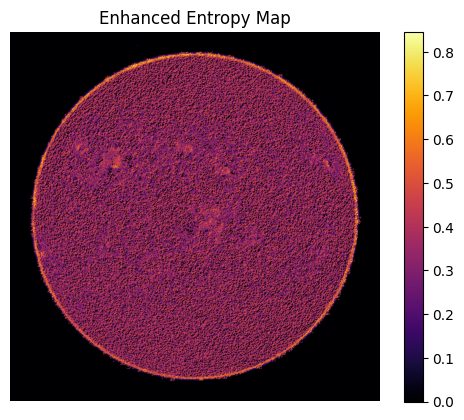

In [6]:
# 🧭 Show enhanced entropy map
plt.imshow(enhanced_entropy, cmap='inferno')
plt.title('Enhanced Entropy Map')
plt.axis('off')
plt.colorbar()
plt.show()

In [7]:
# 📍 DLSFH 20-node vector extraction
angles = np.linspace(0, 2 * np.pi, 21)
radii = [0.3, 0.65]
zones = [(int(cx + r * radius * np.cos((angles[i]+angles[i+1])/2)),
          int(cy + r * radius * np.sin((angles[i]+angles[i+1])/2)))
         for r in radii for i in range(10)]
kernel = 20
vector = np.array([
    np.mean(enhanced_entropy[max(0, y-kernel):min(h, y+kernel), max(0, x-kernel):min(w, x+kernel)])
    for x, y in zones
])
inner = vector[:10]
outer = vector[10:]
divergence = outer - inner
threshold = 0.07

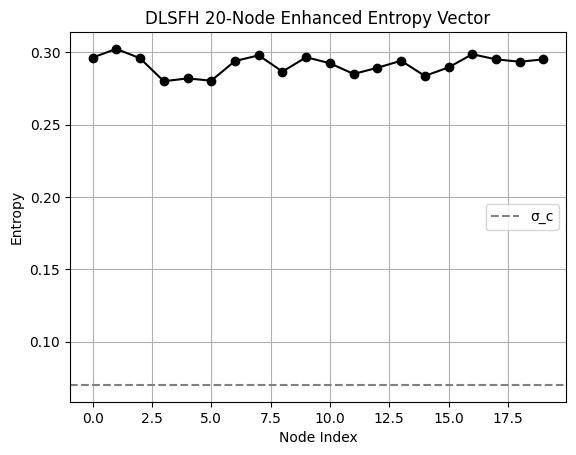

In [8]:
# 📊 Plot 20-node vector
plt.plot(vector, 'o-k')
plt.axhline(threshold, color='gray', linestyle='--', label='σ_c')
plt.title('DLSFH 20-Node Enhanced Entropy Vector')
plt.xlabel('Node Index')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# 🧠 Physics-Based Coherence Analysis
print('=== DLSFH Physics Entropy Summary ===')
print(f'Mean Entropy: {np.mean(vector):.4f} | Std Dev: {np.std(vector):.4f}')
print(f'Collapsed Nodes (≥ {threshold:.2f}): {np.sum(vector >= threshold)} / 20')
print(f'Outer Ring Mean: {np.mean(outer):.4f} | Inner Ring Mean: {np.mean(inner):.4f}')
print(f'Ring Entropy Divergence (Outer - Inner): {np.mean(divergence):.4f}')

if np.sum(vector >= threshold) == 0:
    print('✅ System coherent. Low activity or early-cycle equilibrium.')
elif np.mean(outer) > np.mean(inner):
    print('⚠️ Outer ring decoherence → Surface flux destabilization likely.')
elif np.mean(inner) > np.mean(outer):
    print('⚠️ Inner ring decoherence → Core polarity shift possible.')
if np.std(vector) > 0.01:
    print('🔁 High entropy variance → Possible field asymmetry or flux emergence.')

=== DLSFH Physics Entropy Summary ===
Mean Entropy: 0.2915 | Std Dev: 0.0063
Collapsed Nodes (≥ 0.07): 20 / 20
Outer Ring Mean: 0.2917 | Inner Ring Mean: 0.2913
Ring Entropy Divergence (Outer - Inner): 0.0004
⚠️ Outer ring decoherence → Surface flux destabilization likely.
